# Analysis of Elevation Profiles of Hiking Trails

## Introduction 
This project focuses on the analysis of elevation profiles of hiking trails. The data sources used are hiking trails from [OpenStreetMap (OSM)](https://www.openstreetmap.org) and elevation data from the [DMR 5G](https://ags.cuzk.cz/arcgis/rest/services/3D/dmr5g/ImageServer) obtained from the [Czech Office for Surveying, Mapping and Cadastre (ČÚZK)](https://cuzk.cz). The project primarily focuses on hiking trails marked by the [Czech Tourist Club (KČT)](https://www.kct.cz).

## Limits

The speed of the analysis can vary depending on the analyzed area. In regions with a high density of hiking trails, the processing may take a considerable amount of time, particularly when downloading the trail geometries. This delay is due to the `relation_to_geodataframe(relation)` function, which retrieves trail geometries [OpenStreetMap (OSM)](https://www.openstreetmap.org).

Currently, two libraries are used: [overpy](https://python-overpy.readthedocs.io/) and [osmapi](https://osmapi.readthedocs.io/)  , whose functionalities largely overlap. [Overpy](https://python-overpy.readthedocs.io/) is used to obtain areas by name and to retrieve relations like relation IDs of hiking trails. To download information about the trails, including their geometries, [osmapi](https://osmapi.readthedocs.io/)   is used. This was necessary because errors occurred when attempting to download geometries using [overpy](https://python-overpy.readthedocs.io/).


## Import of libraries

#### Import standard libraries
[numpy](https://numpy.org/)

#### Import libraries for interactive widgets
[ipywidgets](https://ipywidgets.readthedocs.io/en/stable/)   
[ipython](https://ipython.readthedocs.io/en/stable/api/index.html)

#### Import libraries for data and geospatial data processing
[requests](https://docs.python-requests.org/)  
[geopandas](https://geopandas.org/)  
[rasterio](https://rasterio.readthedocs.io/)  
[shapely](https://shapely.readthedocs.io/)  

#### Import libraries for visualization
[matplotlib](https://matplotlib.org/)  
[folium](https://python-visualization.github.io/folium/)  

#### Import libraries for working with OSM data
[osmapi](https://osmapi.readthedocs.io/)  
[overpy](https://python-overpy.readthedocs.io/)

In [34]:
# Import Standard Libraries
import numpy as np

# Import Libraries for Interactive Widgets
import ipywidgets as widgets
from IPython.display import display

# Import Libraries for Data and Geospatial Processing
import requests # for dwnload od raster
#import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import mapping, Point, LineString, MultiLineString, Polygon

# Import Libraries for Visualization
import matplotlib.pyplot as plt
#import folium
#from folium.plugins import MarkerCluster

# Import Libraries for Working with OSM Data
import osmapi # used to download used to downloat path information and geometries
import overpy # used to download area id, paths in area

## Issue with UnicodeDecodeError when downloading raster

When a raster is downloaded after importing all libraries, a UnicodeDecodeError is displayed. It was found that if a random raster is downloaded before importing all libraries, and then the libraries are imported, the raster downloading works correctly. You can try run the code without this cell and you will see what's the problem. If you then restart the kernel and run all the cells in a row, the code will work correctly.

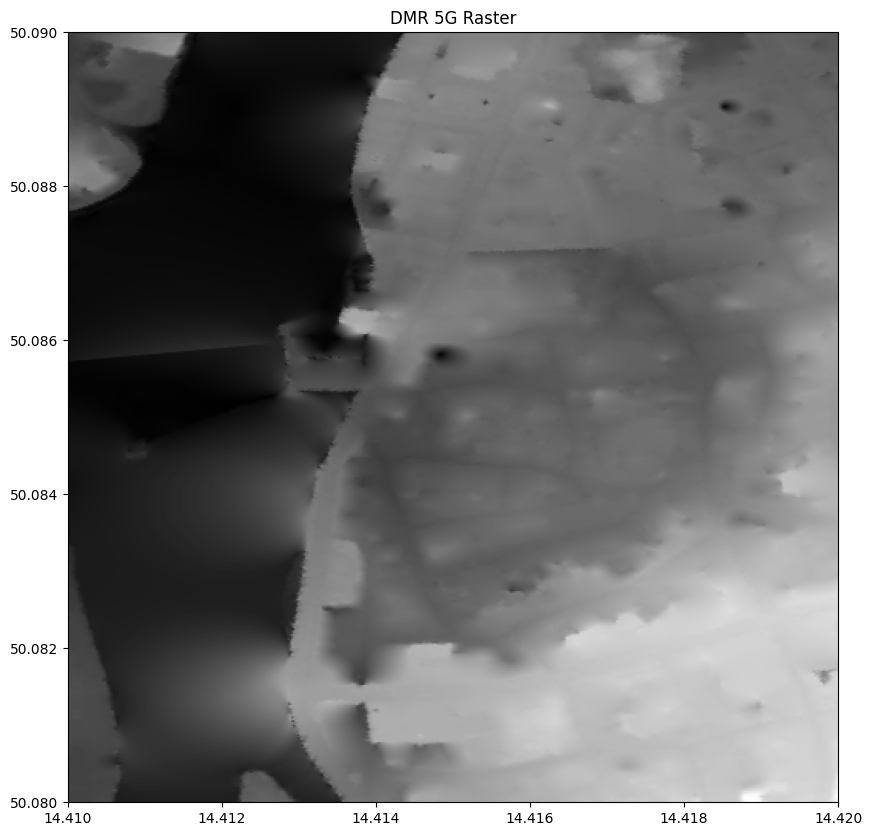

In [35]:
# Bounding box coordinates for a small area in Prague
bbox = [14.41, 50.08, 14.42, 50.09]

# URL for the image server
url = "https://ags.cuzk.cz/arcgis2/rest/services/dmr5g/ImageServer/exportImage"

# Parameters for the request
params = {
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",  # Bounding box coordinates (minx, miny, maxx, maxy)
    "bboxSR": 4326,  # Spatial reference system for the bounding box (WGS 84)
    "imageSR": 4326,  # Spatial reference system for the image (WGS 84)
    "size": "500,500",  # Fixed image size (in pixels)
    "format": "tiff",  # Output format (TIFF)
    "f": "image"  # Request for an image (raster data)
}

# Send the request to the server
response = requests.get(url, params=params)

if response.status_code == 200:
    # Save the response content (TIFF file) to a local file
    with open("dmr5g_bounding_box.tif", "wb") as f:
        f.write(response.content)

    # Open the saved TIFF file using rasterio
    with rasterio.open("dmr5g_bounding_box.tif") as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Display the raster image
        show(src, ax=ax, cmap='gray')
        
        # Add a title
        plt.title("DMR 5G Raster")
        
        # Show the plot
        plt.show()
else:
    print(f"Failed to download raster data. Status code: {response.status_code}")

#### Additional import of commented libraries

In [36]:
# Import of libraries that makes problem when are imported before raster download
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

## Initialize Overpass API

To use Overpass API with the Overpy library, it is important to initialize the API object. This object is used to send queries and retrieve data.

In [37]:
# Initialize Overpass API
api = overpy.Overpass()

## Download of hiking routes

#### Getting the area ID by place name

This function returns the area ID for a given place name using the Overpass API. The area ID is further used to obtain tourist routes in the selected area.

In [38]:
# Function to get the area ID by place name
def get_area_id(area_name):
    """
    Get the area ID for a given place name using the Overpass API.

    Parameters:
    area_name (str): The name of the place to search for.

    Returns:
    int or None: The ID of the area if found, otherwise None.
    """
    # Query to get the area ID for the given place name
    area_query = f"""
    [out:json];
    area["name"="{area_name}"]["boundary"="administrative"];
    out body;
    """
    area_result = api.query(area_query)
    if len(area_result.areas) == 0:
        return None
    return area_result.areas[0].id

#### Fetch hiking routes by KČT for the specified area

This function returns the hiking routes managed by the Czech Tourist Club (KČT) for a specified area using the Overpass API. The area is identified by its ID.

In [39]:
# Function to fetch hiking routes by KČT for the specified area
def fetch_hiking_routes(area_id):
    """
    Fetch the hiking routes by KČT for the specified area using the Overpass API.

    Parameters:
    area_id (int): The ID of the area to search within.

    Returns:
    overpy.Result: The result containing the IDs of the hiking routes.
    """
    # Query to get the IDs of hiking routes by KČT for the specified area
    relation_query = f"""
    [out:json];
    area({area_id});
    relation(area)["route"="hiking"]["operator"="cz:KČT"];
    out ids;
    """
    result = api.query(relation_query)
    return result

#### Download a relation by its ID

This function downloads a relation by its ID using the OSM API.

In [40]:
# Function to download a relation by its ID using osmapi
def download_relation(relation_id):
    """
    Download a relation by its ID using the Overpass API.

    Parameters:
    relation_id (int): The ID of the relation to download.

    Returns:
    dict or None: The relation data if found, otherwise None.
    """
    try:
        with osmapi.OsmApi() as osm_api:
            return osm_api.RelationGet(relation_id)
    except osmapi.errors.ElementDeletedApiError:
        print(f"Relation with ID {relation_id} not found.")
        return None

#### Download hiking routes

This function downloads hiking routes for a specified area. Takes user input which is "area name"

In [41]:
def download_hiking_routes():
    """
    Download hiking routes for a specified area.

    Takes user input which is "area name"

    Returns:
    list or None: A list of hiking routes if found, otherwise None.
    """
    area_name = input("Enter the name of the area: ")
    area_id = get_area_id(area_name)
    
    if area_id is None:
        print(f"{area_name} not found")
        return None
    
    result = fetch_hiking_routes(area_id)
    print(result)
    
    relations = []
    for relation in result.relations:
        rel = download_relation(relation.id)
        if rel:
            relations.append(rel)
    
    if relations:
        print(f"{len(relations)} hiking routes for {area_name}.")
        return relations
    else:
        print(f"No hiking routes were found in {area_name}.")
        return None

#### User input of area name

This block of code asks the user for the name of the municipalyty for which the hiking routes should be found.

In [42]:
if __name__ == "__main__": relations = download_hiking_routes()

Enter the name of the area:  Třebívlice


2 hiking routes for Třebívlice.


#### Function to extract descriptive route information from a relation

This function extracts descriptive information about a hiking route from a given relation. It retrieves various tags and organizes them into a dictionary.

In [43]:
# Function to extract descriptive route information from a relation created by OSMAPI
def extract_route_info(relation):
    """
    Extract descriptive route information from a relation.

    Parameters:
    relation (dict): The relation data from which to extract information.

    Returns:
    dict: A dictionary containing descriptive information about the route.
    """
    tags = relation.get('tag', {})
    route_info = {
        'id': relation['id'],
        'name': tags.get('name', 'Name not provided'),
        'official_name': tags.get('official_name', 'Official name not provided'),
        'route_type': tags.get('route', 'Unknown route type'),
        'operator': tags.get('operator', 'Operator not provided'),
        'symbol': tags.get('osmc:symbol', 'Symbol not provided'),
        'ref': tags.get('ref', 'Reference not provided'),
        'complete': tags.get('complete', 'Not specified'),
        'educational': tags.get('educational', 'Not specified'),
        'network': tags.get('network', 'Unknown network'),
        'kct_yellow': tags.get('kct_yellow', 'Not specified'),
        'note': tags.get('note', 'No note provided'),
    }
    return route_info

#### Print route information

This block of code prints descriptive information about each hiking route. It iterates through the list of relations, extracts the route information, and prints it.

In [44]:
# Print route info
for rel in relations:
    route_info = extract_route_info(rel)
    print("Descriptive information about the path:")
    for key, value in route_info.items():
        print(f"{key}: {value}")
    print("\n")

Descriptive information about the path:
id: 1070713
name: [Č] Teplice - Třebívlice
official_name: Official name not provided
route_type: hiking
operator: cz:KČT
symbol: red:white:red_bar
ref: 0353
complete: yes
educational: Not specified
network: rwn
kct_yellow: Not specified
note: červená: Teplice - Třebívlice


Descriptive information about the path:
id: 1173516
name: Name not provided
official_name: Official name not provided
route_type: hiking
operator: cz:KČT
symbol: blue:white:blue_bar
ref: 1605
complete: yes
educational: Not specified
network: rwn
kct_yellow: Not specified
note: No note provided




#### Function to determine the trail color from the "osmc:symbol" tag

This function determines the color of a hiking trail based on the "osmc:symbol" tag. It maps specific keywords in the symbol to corresponding colors.


In [45]:
# Function to determine the trail color from the "osmc:symbol" tag
def get_trail_color(symbol):
    """
    Determine the trail color from the "osmc:symbol" tag.

    Parameters:
    symbol (str): The "osmc:symbol" tag value.

    Returns:
    str: The color of the trail.
    """
    # Examples of mapping the symbol to a color (you can add more symbols as needed)
    if 'yellow' in symbol:
        return 'yellow'
    elif 'red' in symbol:
        return 'red'
    elif 'green' in symbol:
        return 'green'
    elif 'blue' in symbol:
        return 'blue'
    else:
        return 'gray'  # Default color if no match

#### Function to create a route color dictionary

This function creates a dictionary where the key is the hiking route ID and the value is its color. It processes a list of relations, extracts route information, determines the color based on the "osmc:symbol" tag, and stores the results in a dictionary.

In [46]:
def create_route_color_dict(relations):
    """
    Create a dictionary where the key is the hiking route ID and the value is its color.

    Parameters:
    relations (list): A list of relations representing hiking routes.

    Returns:
    dict: A dictionary mapping route IDs to their colors.
    """
    route_color_dict = {}
    
    for rel in relations:
        # Get route information
        route_info = extract_route_info(rel)
        symbol = route_info.get('symbol', '')  # Get the osmc:symbol tag
        color = get_trail_color(symbol)  # Determine the color based on the symbol
        
        # Store in the dictionary
        route_color_dict[route_info['id']] = color
    
    return route_color_dict

#### Print route IDs and colors

This block of code checks if any hiking routes were found. If routes are found, it creates a dictionary mapping route IDs to their colors and prints the dictionary. If no routes are found, it prints a message indicating that no routes were found.

In [47]:
if relations:
    route_color_dict = create_route_color_dict(relations)
    print("Dictionary with route IDs and colors:")
    for route_id, color in route_color_dict.items():
        print(f"Route ID: {route_id}, color: {color}")
else:
    print("No hiking routes were found.")

Dictionary with route IDs and colors:
Route ID: 1070713, color: red
Route ID: 1173516, color: blue


#### Function to convert a relation to a GeoDataFrame

This function converts a relation to a GeoDataFrame using osmapi. I could be improoved by using Overpy

In [48]:
def relation_to_geodataframe(relation):
    """
    Convert a relation to a GeoDataFrame.

    Parameters:
    relation (dict): The relation data containing members.

    Returns:
    GeoDataFrame: A GeoDataFrame containing the geometries of the relation members.
    """
    members = relation.get('member', [])
    data = []
    
    for member in members:
        member_type = member.get('type')
        ref = member.get('ref')
        role = member.get('role', '')
        
        if member_type == 'way':
            # Fetch geometry for "way" using the API
            with osmapi.OsmApi() as api:
                way = api.WayGet(ref)
                nodes = way['nd']
                coords = [(api.NodeGet(node_id)['lon'], api.NodeGet(node_id)['lat']) for node_id in nodes]
                geometry = LineString(coords)
                data.append({
                    'type': member_type,
                    'ref': ref,
                    'role': role,
                    'geometry': geometry
                })

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry='geometry')
    return gdf

#### Function to convert relations to a GeoDataFrame dictionary

This function converts a list of relations into a dictionary where each key is a relation ID and each value is a GeoDataFrame. It processes each relation, extracts its ID, and stores a placeholder for the GeoDataFrame.

In [49]:
def relations_to_geodataframe_dict(relations):
    """
    Convert a list of relations to a dictionary of GeoDataFrames.

    Parameters:
    relations (list): A list of relation objects.

    Returns:
    dict: A dictionary where the keys are relation IDs and the values are GeoDataFrames.
    """
    geodataframe_dict = {}  # Initialize an empty dictionary

    # Iterate through each relation in the list of relations
    for rel in relations:
        # Get the relation ID (you can use any other attribute of the relation instead)
        rel_id = rel['id']
        
        # For now, store None until we have a function to convert to GeoDataFrame
        geodataframe_dict[rel_id] = relation_to_geodataframe(rel)

    return geodataframe_dict

#### Create a dictionary of GeoDataFrames from relations

This code creates a dictionary where each key is a relation ID and each value is a GeoDataFrame. It uses the `relations_to_geodataframe_dict` function to process a list of relations, extract their IDs, and convert them into GeoDataFrames.

In [50]:
# Create a dictionary where keys are relation IDs and values are GeoDataFrames
gdf_dict = relations_to_geodataframe_dict(relations)

# Test print
print(gdf_dict)

{1070713:     type         ref role                                           geometry
0    way   116419194       LINESTRING (13.89870 50.45809, 13.89858 50.458...
1    way   304772357       LINESTRING (13.89792 50.46275, 13.89769 50.463...
2    way   116419215       LINESTRING (13.89583 50.46921, 13.89581 50.468...
3    way    28157481       LINESTRING (13.89583 50.46921, 13.89538 50.469...
4    way   904306035       LINESTRING (13.88830 50.47807, 13.88812 50.478...
..   ...         ...  ...                                                ...
112  way   721886065       LINESTRING (13.83369 50.64350, 13.83414 50.643...
113  way   267179037       LINESTRING (13.83219 50.64448, 13.83295 50.643...
114  way  1304024594       LINESTRING (13.83183 50.64471, 13.83219 50.64448)
115  way  1304024595       LINESTRING (13.83148 50.64493, 13.83183 50.64471)
116  way   267179041       LINESTRING (13.83148 50.64493, 13.83130 50.644...

[117 rows x 4 columns], 1173516:    type        ref role         

#### Combine dictionaries

This code combines dictionaries to create a new dictionary where each key is a route ID and each value is a tuple containing a GeoDataFrame and a color. It uses the `gdf_dict` for GeoDataFrames and `route_color_dict` for colors.

In [51]:
# Combine dictionaries: Route ID -> (GeoDataFrame, color)
combined_dict = {}

for route_id, gdf in gdf_dict.items():
    color = route_color_dict.get(route_id, 'gray')  # Default color 'gray' if ID is missing
    combined_dict[route_id] = {'geodataframe': gdf, 'color': color}

# Test print
for route_id, data in combined_dict.items():
    print(f"Route ID: {route_id}, color: {data['color']}")
    print(data['geodataframe'].head())  # Print first few rows of GeoDataFrame
    print("\n")

Route ID: 1070713, color: red
  type        ref role                                           geometry
0  way  116419194       LINESTRING (13.89870 50.45809, 13.89858 50.458...
1  way  304772357       LINESTRING (13.89792 50.46275, 13.89769 50.463...
2  way  116419215       LINESTRING (13.89583 50.46921, 13.89581 50.468...
3  way   28157481       LINESTRING (13.89583 50.46921, 13.89538 50.469...
4  way  904306035       LINESTRING (13.88830 50.47807, 13.88812 50.478...


Route ID: 1173516, color: blue
  type        ref role                                           geometry
0  way  295505482       LINESTRING (13.89933 50.45819, 13.89907 50.458...
1  way  116419171       LINESTRING (13.90066 50.45839, 13.90046 50.458...
2  way  116419178       LINESTRING (13.90052 50.46278, 13.90058 50.462...
3  way  627891874       LINESTRING (13.90318 50.46414, 13.90243 50.463...
4  way  116419212       LINESTRING (13.90390 50.46500, 13.90377 50.464...




## Visualization of hiking routes

#### Create map of the Czech Republic

This code creates a map using Folium. It adds a separate MarkerCluster for each route to ensure that clusters of different routes do not merge. Each cluster is customized to display the route ID with the correct color. The code iterates through the routes, adds them to the map as GeoJSON objects with appropriate styling, and places text labels on the lines to indicate the route ID.

In [52]:
from folium.plugins import MarkerCluster

# Create the base map
m = folium.Map(location=[50, 15], zoom_start=7)

# Iterate through routes and add them to the map
for route_id, data in combined_dict.items():
    # Create a separate MarkerCluster for each route with custom popups
    route_cluster = MarkerCluster(
        # Define a JavaScript function to create custom icons for clusters
        icon_create_function=f"""
        function(cluster) {{
            // Get the number of markers in the cluster
            var childCount = cluster.getChildCount();
            
            // Initialize a variable to hold the class name for the cluster icon
            var c = ' marker-cluster-';
            
            // Determine the class name based on the number of markers in the cluster
            if (childCount < 10) {{
                // If there are fewer than 10 markers, use the 'small' class
                c += 'small';
            }} else if (childCount < 100) {{
                // If there are between 10 and 99 markers, use the 'medium' class
                c += 'medium';
            }} else {{
                // If there are 100 or more markers, use the 'large' class
                c += 'large';
            }}
            
            // Create a new DivIcon for the cluster
            return new L.DivIcon({{ 
                // Set the HTML content of the icon, including the route ID and color
                html: '<div style="color: {data["color"]};"><span>{route_id}</span></div>', 
                // Set the class name for the icon, combining the base class with the size class
                className: 'marker-cluster' + c, 
                // Set the size of the icon
                iconSize: new L.Point(40, 40) 
            }});
        }}
        """
    ).add_to(m)  # Add the MarkerCluster to the map
    
    # Add route as GeoJSON with the correct color
    folium.GeoJson(
        data['geodataframe'].geometry.unary_union,
        style_function=lambda feature, color=data['color']: {
            'fillcolor': color, 
            'color': color, 
            'weight': 2, 
            'fillOpacity': 0.5
        }
    ).add_to(route_cluster)

    # Add description along the line
    for line in data['geodataframe'].geometry:
        folium.Marker(
            location=[line.centroid.y, line.centroid.x],
            popup=f"Route ID: {route_id}",  # Use route_id directly
            icon=folium.DivIcon(
                icon_size=(150, 36), icon_anchor=(7, 20),
                # Set up HTML style
                html=f'<div style="font-size: 10pt; color: {data["color"]};">{route_id}</div>'  # Use route_id directly
            )
        ).add_to(route_cluster)

display(m)

## Selection of hiking routes for analysis

#### Select a GeoDataFrame by route ID

this function selects a geodataframe from a dictionary by the specified id

In [53]:
def select_geodataframe(gdf_dict, route_id):
    # Verify that the route ID exists in the dictionary
    if route_id in gdf_dict:
        geodataframe = gdf_dict[route_id]  # Return the GeoDataFrame for the given ID
        
        # Check if the GeoDataFrame is empty
        if geodataframe.empty:
            print(f"The GeoDataFrame for route {route_id} is empty.")
            return None
        
        print(f"GeoDataFrame for route ID {route_id} has been selected.")
        return geodataframe
    else:
        print(f"Route ID {route_id} is not in the dictionary.")
        return None

#### User selection of id from list of ids
This code creates an interactive widget using `ipywidgets` in Python. It allows the user to select a value from a dropdown menu and confirm their selection with a button. The selected value is stored in a global variable and printed to the console.

In [54]:
# Create a list of values
values = list(combined_dict.keys())

# Create a dropdown widget
dropdown = widgets.Dropdown(
    options=values,
    value=values[0],
    description='Select id:',
)

# Global variable to store the selected value
selected_value = values[0]

# Function to display and store the selected value
def on_change(change):
    global selected_value
    selected_value = change['new']
    print(f'Selected value: {selected_value}')

# Attach the function to the value change event
dropdown.observe(on_change, names='value')

# Create a button to confirm the selection
confirm_button = widgets.Button(description="Confirm")

# Function to handle button click
def on_button_clicked(b):
    global selected_value
    print(f'Confirmed value: {selected_value}')

# Attach the function to the button click event
confirm_button.on_click(on_button_clicked)

# Display the dropdown widget and the button side by side
display(widgets.HBox([dropdown, confirm_button]))

#### Call the Function and Work with the Selected GeoDataFrame

This code calls the `select_geodataframe` function to select a GeoDataFrame from the dictionary.

In [55]:
route_id = selected_value  # Selected ID
gdf = select_geodataframe(gdf_dict, route_id)

GeoDataFrame for route ID 1070713 has been selected.


#### Check if the selected data type is GeoDataFrame

In [56]:
if isinstance(gdf, gpd.GeoDataFrame):
    print("gdf is GeoDataFrame.")
else:
    print("gdf is not GeoDataFrame.")

gdf is GeoDataFrame.


#### Getting informations about selected route

In [57]:
# Getting info about the route
relation = download_relation(route_id)

# Extract information dictionary
route_info = extract_route_info(relation)

# Retrieve the trail symbol for examole "green:white:green_bar"
trail_symbol = route_info.get('symbol')

# Map the trail symbol to a corresponding color for visualization
trail_color = get_trail_color(trail_symbol)

# Retrieve the name of the route
route_name = route_info.get('name', 'No name provided')

#### Display selected route

In [58]:
# Get GeoDataFrame bounding box
bbox = gdf.total_bounds

# Calculate map center
center = [(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2]

# Create map with center and zoom
m = folium.Map(location=center, zoom_start=10)

# Add GeoDataFrame to map
gdf.explore(m=m, tiles="carto positron", color=trail_color)

# display map
display(m)

## Downoload of raster
Getting size of bounding box (DMR5G tile).

In [59]:
# Calculate the width and height from the bounding box
minx, miny, maxx, maxy = bbox
width = maxx - minx
height = maxy - miny

max_size = 500  # Maximum dimension size (for width or height)

aspect_ratio = width / height

if width > height:
    image_width = max_size
    image_height = int(image_width / aspect_ratio)
else:
    image_height = max_size
    image_width = int(image_height * aspect_ratio)

#### Download of raster via request

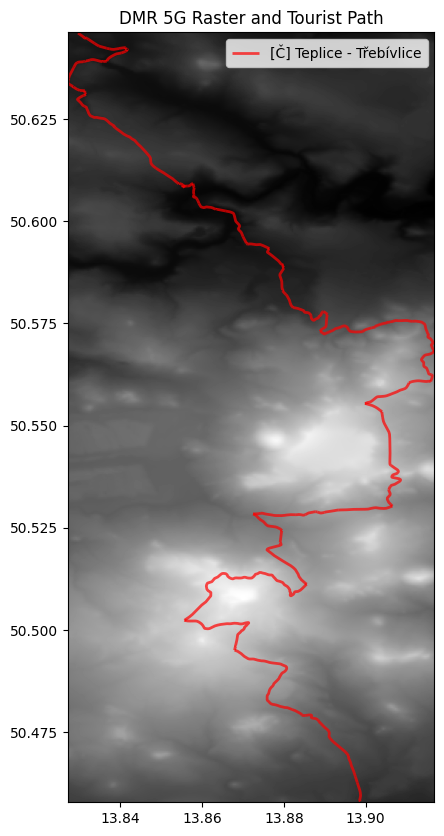

In [60]:
url = "https://ags.cuzk.cz/arcgis2/rest/services/dmr5g/ImageServer/exportImage"

params = {
    "bbox": f"{minx},{miny},{maxx},{maxy}",  # Bounding box coordinates (minx, miny, maxx, maxy)
    "bboxSR": 4326,  # Spatial reference for the bounding box (WGS 84)
    "imageSR": 4326,  # Spatial reference for the image (WGS 84)
    "size": f"{image_width},{image_height}",  # Dynamically set image size (in pixels)
    "format": "tiff",  # Output format (TIFF)
    "f": "image"  # Requesting the image (raster data)
}

response = requests.get(url, params=params)

if response.status_code == 200:
    # Save the response content (TIFF file) to a local file
    with open("dmr5g_bounding_box.tif", "wb") as f:
        f.write(response.content)

    #Open the saved TIFF file using rasterio
    with rasterio.open("dmr5g_bounding_box.tif") as src:

        fig, ax = plt.subplots(figsize=(10, 10))
        
        show(src, ax=ax, cmap='gray')
        
        gdf.plot(ax=ax, color=trail_color, alpha=0.7, edgecolor='black', linewidth=2, label=route_name)
        
        # Add a title
        plt.title("DMR 5G Raster and Tourist Path")
        
        # Display the plot
        plt.legend()
        plt.show()

else:
    print(f"Failed to download raster data. Status code: {response.status_code}")

## Transformation and Length Calculation of the Route
Determine the current CRS, which is initially undefined but is obviously in geographic coordinates, so WGS84 is set up. Then, transform to S-JTSK for length calculation with minimal distortion. Finally, calculate the length and transform the coordinates back to WGS84.

In [61]:
# Print the current coordinate reference system (CRS)
print(f"current crs is: {gdf.crs}")

# Setup crs to WGS84 (EPSG:4326)
gdf_length = gdf.set_crs(epsg=4326, allow_override=True)

# Convert to metric CRS (EPSG:5514) for length calculation of length
gdf_length = gdf_length.to_crs(epsg=5514)

# Calculate length
gdf_length['length'] = gdf_length.length

# Transform back to WGS84
gdf_length = gdf_length.set_crs(epsg=4326, allow_override=True)

# Print head of data
print(gdf_length.head())

current crs is: None
  type        ref role                                           geometry  \
0  way  116419194       LINESTRING (-773931.25691 -996988.67331, -7739...   
1  way  304772357       LINESTRING (-773911.60568 -996467.94696, -7739...   
2  way  116419215       LINESTRING (-773955.16597 -995735.76958, -7739...   
3  way   28157481       LINESTRING (-773955.16597 -995735.76958, -7739...   
4  way  904306035       LINESTRING (-774343.24801 -994682.97511, -7743...   

        length  
0   526.613553  
1   162.925662  
2   572.648314  
3  1144.397277  
4   297.772006  


## Calculate height of segments
Calculate height of segments of hiking route and adding them to GeoDataFrame.

#### Open the Raster File
Open the raster file and initialize an empty list to store elevation data.

In [62]:
# Open the raster file
with rasterio.open("dmr5g_bounding_box.tif") as src:
    elevation_data = []

    # Iterate over each line in the GeoDataFrame geometry
    for line in gdf.geometry:
        for coord in line.coords:
            lon, lat = coord

            # Get the row and column index for the given coordinates
            row, col = src.index(lon, lat)

            # Check if the indices are within the bounds of the raster
            if 0 <= row < src.height and 0 <= col < src.width:
                elevation = src.read(1)[row, col]
            else:
                elevation = None
            elevation_data.append({'lon': lon, 'lat': lat, 'elevation': elevation})

#### Calculate elevation
In this section, a GeoDataFrame is created from the elevation data. The coordinate reference system (CRS) of the original GeoDataFrame is WGS84 (EPSG:4326) and has been converted to S-JTSK (EPSG:5514) for accurate length calculation. The length of each segment is calculated and stored in a new column 'length'. The 'elevation' column is initialized in the original GeoDataFrame to store elevation data. Iterating over each row in the GeoDataFrame, the coordinates are matched with elevation data from the newly created GeoDataFrame, and the 'elevation' column is updated. Finally, the 'length' column from the transformed GeoDataFrame is added to the original GeoDataFrame, and the first rows of the GeoDataFrame with the updated 'geometry', 'elevation', and 'length' columns are printed.

In [63]:
# Create a GeoDataFrame from the elevation data
elevation_gdf = gpd.GeoDataFrame(
    elevation_data, 
    geometry=gpd.points_from_xy([d['lon'] for d in elevation_data], [d['lat'] for d in elevation_data]),
    crs="EPSG:4326"
)

# Set the CRS of the original GeoDataFrame and convert it to a different CRS
gdf_length = gdf.set_crs(epsg=4326, allow_override=True)
gdf_length = gdf_length.to_crs(epsg=5514)
gdf_length['length'] = gdf_length.length

# Initialize the 'elevation' column in the original GeoDataFrame
gdf['elevation'] = None

# Iterate over each row in the GeoDataFrame
for idx, line in gdf.iterrows():
    for coord in line['geometry'].coords:
        lon, lat = coord
        elevation = elevation_gdf[(elevation_gdf['lon'] == lon) & (elevation_gdf['lat'] == lat)]['elevation'].values
        if elevation.size > 0:
            gdf.at[idx, 'elevation'] = elevation[0]

# Add the 'length' column to the original GeoDataFrame
gdf['length'] = gdf_length['length']

# Print the first rows of the GeoDataFrame with geometry, elevation, and length
print(gdf[['geometry', 'elevation', 'length']].head())

                                            geometry   elevation       length
0  LINESTRING (13.89870 50.45809, 13.89858 50.458...   285.67804   526.613553
1  LINESTRING (13.89792 50.46275, 13.89769 50.463...  299.744843   162.925662
2  LINESTRING (13.89583 50.46921, 13.89581 50.468...  299.744843   572.648314
3  LINESTRING (13.89583 50.46921, 13.89538 50.469...  391.016266  1144.397277
4  LINESTRING (13.88830 50.47807, 13.88812 50.478...  406.893219   297.772006


#### NaN values Cleaning
Removing values at the same position from both fields if at least one field contains a NaN value.

In [64]:
# Extract 'elevation' and 'length' columns as numpy arrays, ensuring they are floats
elevations = np.array(gdf['elevation'], dtype=float)
distances = np.array(gdf['length'], dtype=float)

# Find indices where either array has NaN
nan_indices = np.isnan(elevations) | np.isnan(distances)

# Remove NaN values based on these indices
elevations_cleaned = elevations[~nan_indices]
distances_cleaned = distances[~nan_indices]

#### Cumulative Distance Calculation
Calculate the cumulative sum of distances to be used for the x-axis for the elevation profile graph.

In [65]:
# Calculate the cumulative sum of distances
cumulative_distances = np.cumsum(distances_cleaned)

## Elevation Profile Visualization
Create a plot of the elevation profile against the cumulative distances. This visual representation helps to understand the terrain of the tourist path.

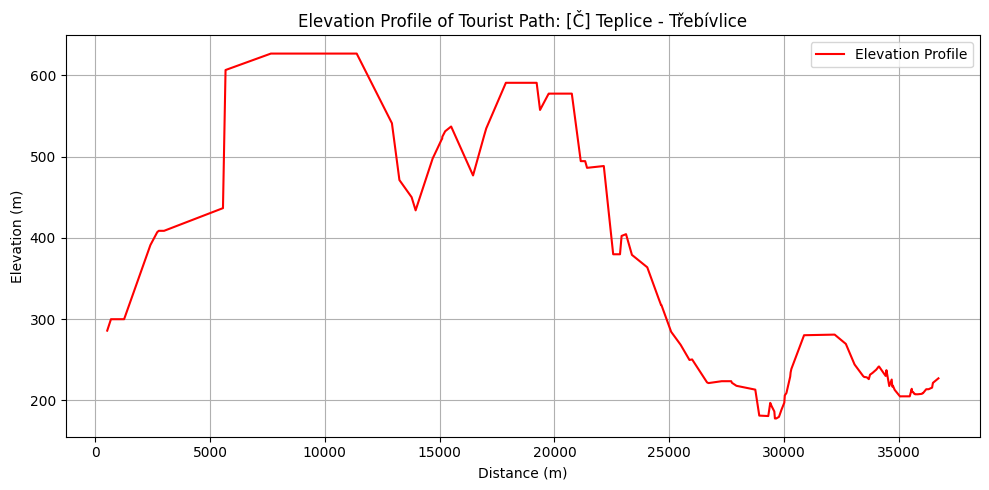

In [66]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the elevation profile against cumulative distances
ax.plot(cumulative_distances, elevations_cleaned, label='Elevation Profile', color=trail_color)

# Set the x-axis label
ax.set_xlabel('Distance (m)')

# Set the y-axis label
ax.set_ylabel('Elevation (m)')

# Set the title of the plot
ax.set_title(f'Elevation Profile of Tourist Path: {route_name}')

# Turn on the grid
ax.grid(True)

# Add a legend to the plot
ax.legend()

# Adjust the layout to fit everything
plt.tight_layout()

# Display the plot
plt.show()